# Crear una red neuronal con un dataset de radiografia de pneumonia

https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

### Importaciones

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import os

from tensorflow import keras
from tensorflow.keras import layers, models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.utils import to_categorical

### Obtener la ruta de todas las imagenes

In [3]:
# Acceder a la carpeta donde estan las imagenes
# Crear el dataframe

imagenes = []
for root, dirs, files in os.walk(".",topdown=False):
    if len(files) != 0:
        for name in files:
            if name.endswith(".jpeg"):
                imagenes.append(os.path.join(root, name))
          

In [22]:
len(imagenes)
# imagenes

5856

### Creamos una lista con los valores de las imagenes y su valor correspondiente de si esta o no enfermo

In [23]:
# Con estado pondremos 0 si esta normal y 1 si tiene pneumonia

col = ["imagen","estado"]
data_rows = []

def get_data():
    row = []
    for i,path in enumerate(imagenes):
        valor = 0
        row = []
        if "PNEUMONIA" in path:
            valor = 1
        img = cv2.imread(path)
        img = cv2.resize(img,(128,128)) 
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        row.append(img_gray)
        row.append(valor)
        data_rows.append(row)
    

    return data_rows

### Obtenemos los datos

In [24]:
data = get_data()

# Barajar la lista y repartir los datos entre train,test y validacion

### Barajamos la lista

In [25]:
import random
random.shuffle(data)

### Dividimos la lista en dos, imagenes y valor de si esta enfermo o no

In [26]:
x, y = zip(*data)
x = np.array(x)
y = np.array(y)

### Dividimos entre train y test

In [27]:
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(x, y, test_size=0.2)

In [28]:
X_train_full.shape

(4684, 128, 128)

### Dividir datos para usar en validacion

In [29]:
X_valid, X_train = X_train_full[:684] / 255., X_train_full[684:] / 255.
y_valid, y_train = y_train_full[:684], y_train_full[684:]
X_test = X_test / 255.


# Creacion y entrenamiento de la red neuronal

In [54]:
model = models.Sequential()
# En Conv2D recomendado usar multiplos de 2
model.add(layers.Conv2D(32,(3,3),activation="relu",input_shape=(128,128,1)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Dense(50,activation="softmax"))
# A la segunda convolucion ya no hace falta ponerle el input_shape
model.add(layers.Conv2D(64,(3,3),activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
# Aplanar la capa
model.add(layers.Flatten())
# Capa de salida
model.add(layers.Dense(10,activation="softmax"))

model.summary()

c:\Users\oscar.torresrodrigue\AppData\Local\miniconda3\envs\tensorflow\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 63, 63, 50)     │         1,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 61, 61, 64)     │        28,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │       576,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 606,844 (2.31 MB)

 Trainable params: 606,844 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# Modelo adam, mas utilizado y recomendado
from keras.optimizers import Adam

adam = Adam(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy",optimizer=adam ,metrics=["accuracy"])

In [56]:
epochs = 1000

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

history = model.fit(X_train,y_train,epochs=epochs,validation_data=(X_valid,y_valid),callbacks=[early_stopping_cb])

Epoch 1/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - accuracy: 0.7002 - loss: 0.7274 - val_accuracy: 0.7164 - val_loss: 0.5848
Epoch 2/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 0.8198 - loss: 0.4009 - val_accuracy: 0.9137 - val_loss: 0.2215
Epoch 3/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 0.9299 - loss: 0.1775 - val_accuracy: 0.9254 - val_loss: 0.2036
Epoch 4/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - accuracy: 0.9410 - loss: 0.1502 - val_accuracy: 0.9211 - val_loss: 0.2138
Epoch 5/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 0.9496 - loss: 0.1443 - val_accuracy: 0.9357 - val_loss: 0.1790
Epoch 6/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step - accuracy: 0.9509 - loss: 0.1268 - val_accuracy: 0.9298 - val_loss: 0.1884
Epoch 7/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 0.9559 - loss: 0.1184 - val_accuracy: 0.9371 - val_loss: 0.1718
Epoch 8/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - accuracy: 

<Axes: >

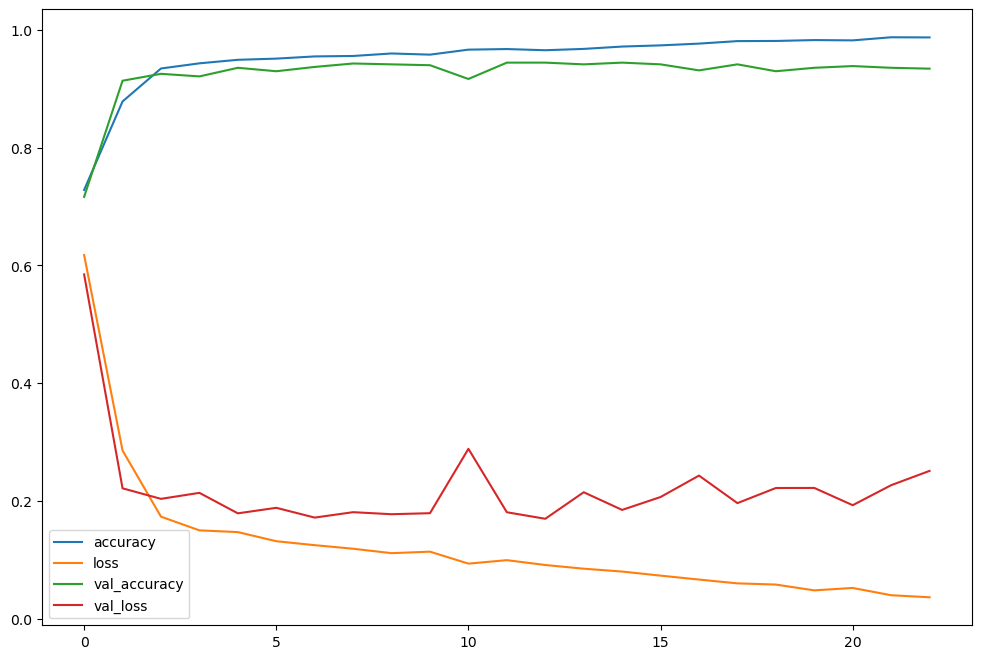

In [57]:
pd.DataFrame(history.history).plot(figsize=(12,8))

In [58]:
model.evaluate(X_test,y_test)

# Imagenes con 256, 256, 1
# 37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.9489 - loss: 0.1472

# Imagenes con 128,128
# 37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9581 - loss: 0.1295


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9575 - loss: 0.1319


[0.1487538069486618, 0.9564846158027649]

In [59]:
y_test_pred = model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
y_test_true_labels = y_test

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


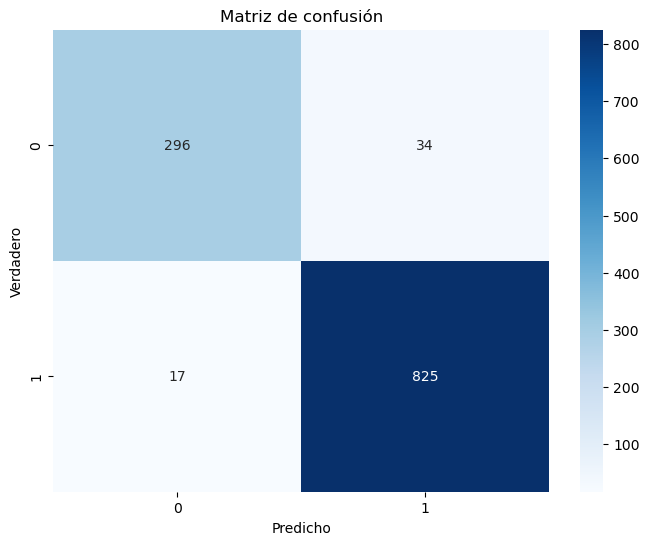

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_true_labels, y_test_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.title('Matriz de confusión')
plt.show()

In [61]:
from sklearn.metrics import classification_report

report = classification_report(y_test_true_labels, y_test_pred_labels, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.9457    0.8970    0.9207       330
           1     0.9604    0.9798    0.9700       842

    accuracy                         0.9565      1172
   macro avg     0.9531    0.9384    0.9454      1172
weighted avg     0.9563    0.9565    0.9561      1172

